In [1]:
from src.scut import *
from src.Zha_clust import *

In [2]:
import json

with open('dataAN/Scrutins.json/json/VTANR5L16V1.json') as f:
    d = json.load(f)

In [3]:
deputes = set()
mandats = set()
for fname in os.listdir('dataAN/Scrutins.json/json/'):
    with open('dataAN/Scrutins.json/json/'+fname) as f:
        d = json.load(f)
    if int(d['scrutin']['syntheseVote']['nombreVotants']) > 577:
        continue
    decompte_par_groupe = d['scrutin']['ventilationVotes']['organe']['groupes']['groupe']
    for g in range(len(decompte_par_groupe)):
        decompte = decompte_par_groupe[g]['vote']['decompteNominatif']
        
        
        try:
            pours = decompte['pours']
        except:
            pours = decompte['pour']
        if pours:
            if type(pours['votant']) == list:
                deputes |= {a['acteurRef'] for a in pours['votant']}
                mandats |= {a['mandatRef'] for a in pours['votant']}
            else:
                deputes.add(pours['votant']['acteurRef'])
                mandats.add(pours['votant']['mandatRef'])
        try:
            contres = decompte['contres']
        except:
            contres = decompte['contre']
        if contres:
            if type(contres['votant']) == list:
                deputes |=  {a['acteurRef'] for a in contres['votant']}
                mandats |= {a['mandatRef'] for a in contres['votant']}
            else:
                deputes.add(contres['votant']['acteurRef'])
                mandats.add(contres['votant']['mandatRef'])
    

vote_count = {depute:0 for depute in deputes}

cpt = 0
for fname in os.listdir('dataAN/Scrutins.json/json/'):
    with open('dataAN/Scrutins.json/json/'+fname) as f:
        d = json.load(f)
    if int(d['scrutin']['syntheseVote']['nombreVotants']) > 577:
        continue
    cpt += 1
    decompte_par_groupe = d['scrutin']['ventilationVotes']['organe']['groupes']['groupe']
    for g in range(len(decompte_par_groupe)):
        decompte = decompte_par_groupe[g]['vote']['decompteNominatif']
        
        
        try:
            pours = decompte['pours']
        except:
            pours = decompte['pour']
        if pours:
            if type(pours['votant']) == list:
                for a in pours['votant']:
                    vote_count[a['acteurRef']] += 1
                #deputes |= {a['acteurRef'] for a in pours['votant']}
            else:
                vote_count[pours['votant']['acteurRef']] += 1
                #deputes.add(pours['votant']['acteurRef'])
        try:
            contres = decompte['contres']
        except:
            contres = decompte['contre']
        if contres:
            if type(contres['votant']) == list:
                for a in contres['votant']:
                    vote_count[a['acteurRef']] += 1
                #deputes |=  {a['acteurRef'] for a in contres['votant']}
            else:
                vote_count[contres['votant']['acteurRef']] += 1
                #deputes.add(contres['votant']['acteurRef'])

PA_ID_2_idx = {k:e for e,k in enumerate(vote_count.keys())}

data = np.zeros((605,4106))
data_json = os.listdir('dataAN/Scrutins.json/json/')


cpt = 0

for fname in data_json:
    with open('dataAN/Scrutins.json/json/'+fname) as f:
        d = json.load(f)
    #if int(d['scrutin']['syntheseVote']['nombreVotants']) > 577:
    #    continue

    decompte_par_groupe = d['scrutin']['ventilationVotes']['organe']['groupes']['groupe']
    for g in range(len(decompte_par_groupe)):
        decompte = decompte_par_groupe[g]['vote']['decompteNominatif']
        
        try:
            pours = decompte['pours']
        except:
            pours = decompte['pour']
        if pours:
            if type(pours['votant']) == list:
                for a in pours['votant']:
                    if a['acteurRef'] in PA_ID_2_idx:
                        idx = PA_ID_2_idx[a['acteurRef']]
                        data[idx][cpt] = 1
                    
                
            else:
                if pours['votant']['acteurRef'] in PA_ID_2_idx:
                    idx = PA_ID_2_idx[pours['votant']['acteurRef']]
                    data[idx][cpt] = 1
                
        try:
            contres = decompte['contres']
        except:
            contres = decompte['contre']
        if contres:
            if type(contres['votant']) == list:
                for a in contres['votant']:
                    if a['acteurRef'] in PA_ID_2_idx:
                        idx = PA_ID_2_idx[a['acteurRef']]
                        data[idx][cpt] = -1

            else:
                if contres['votant']['acteurRef'] in PA_ID_2_idx:
                    idx = PA_ID_2_idx[contres['votant']['acteurRef']]
                    data[idx][cpt] = -1
    
    cpt+= 1


data_filled = np.copy(data)

cpt = 0

for fname in data_json:
    with open('dataAN/Scrutins.json/json/'+fname) as f:
        d = json.load(f)
    #if int(d['scrutin']['syntheseVote']['nombreVotants']) > 577:
    #    continue
    
    adopte = (d['scrutin']['syntheseVote']['annonce'] == "l'Assemblée nationale a adopté")
    
    
    for j in range(605):
        if data_filled[j][cpt] == 0:
            if adopte:
                data_filled[j][cpt] = 0.5
            else:
                data_filled[j][cpt] = -0.5
    
    cpt += 1
    
graph_data = (data_filled+1)/2


In [19]:
res = []
for fname in data_json:
    with open('dataAN/Scrutins.json/json/'+fname) as f:
        d = json.load(f)
    if int(d['scrutin']['syntheseVote']['nombreVotants']) > 577:
        continue
        
    for i in d['scrutin']["ventilationVotes"]['organe']['groupes']['groupe']:
        if i['organeRef'] not in res:
            res.append(i['organeRef'])

belongs = dict()
for fname in list(PA_ID_2_idx.keys()):
    belongs[fname] = []
    with open('dataAN/AMO30_tous_acteurs_tous_mandats_tous_organes_historique.json/json/acteur/'+fname+".json") as f:
        text = f.read()
    for PO in res:
        if PO in text:
            belongs[fname].append(PO)

PO_2_hex_lab = dict()
for fname in res:
    with open('dataAN/AMO30_tous_acteurs_tous_mandats_tous_organes_historique.json/json/organe/'+fname+".json") as f:
        d = json.load(f)
        #print(fname, d['organe']['couleurAssociee'] ,d['organe']['libelle'])
        PO_2_hex_lab[fname] = (d['organe']['couleurAssociee'],d['organe']['libelle'] )
        
PO_2_hex_lab["PO793087"] = ('#ffffff', 'Non inscrit')

l_pos = ["Left-wing","Center","Right-wing","Far-right"]

belongs_short = {k:tuple([j for j in i if j!='PO793087'and j!='PO830170']) for k,i in belongs.items()}
belongs_short["PA721522"] = ("PO800538",)
belongs_short["PA719032"] = ("PO800538",)
belongs_short["PA267042"] = ("PO800514",)
belongs_short["PA794914"] = ("PO800508",)
belongs_short["PA722070"] = ("PO800538",)

with open('iTOL/AN/itol_fr_an_16_strip.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tGroupes parlementaires\n")
    f.write("COLOR\t#0000ff\n")
    f.write("LEGEND_TITLE\tGroupes parlementaires\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*(len(PO_2_hex_lab)-1)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join([i[0] for i in PO_2_hex_lab.values()][:-1])+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join([i[1] for i in PO_2_hex_lab.values()][:-1])+"\n")
    f.write("DATA\n")
    
    for k,v in belongs_short.items():
        for PO in v:
            hex_rgb, lab = PO_2_hex_lab[PO]
            f.write(k+"\t"+hex_rgb+"\t"+lab+"\n")

l_pos = ["Left-wing","Centre","Right-wing","Far-right"]
l_col = ["#d30b0d","#ffd100","#428bca","#834333"]

dict_pos = dict()
dict_pos["Renaissance"] = "Centre"
dict_pos["Rassemblement National"] = "Far-right"
dict_pos['La France insoumise - Nouvelle Union Populaire écologique et sociale'] = "Left-wing"
dict_pos['Les Républicains'] = "Right-wing"
dict_pos['Démocrate (MoDem et Indépendants)'] = "Centre"

dict_pos['Démocrate (MoDem et Indépendants)'] = "Centre"
dict_pos['Socialistes et apparentés (membre de l’intergroupe NUPES)'] = "Left-wing"
dict_pos['Horizons et apparentés'] = "Centre"
dict_pos['Écologiste - NUPES'] = "Left-wing"
dict_pos['Gauche démocrate et républicaine - NUPES'] = "Left-wing"
dict_pos['Libertés, Indépendants, Outre-mer et Territoires'] = "Centre"
dict_pos['Socialistes et apparentés'] = "Left-wing"


with open('iTOL/AN/itol_fr_an_16_strip_positionnement.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tPositionnement\n")
    f.write("COLOR\t#0000ff\n")
    f.write("LEGEND_TITLE\tPositionnement\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_pos)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_pos)+"\n")
    f.write("DATA\n")
    
    for k,v in belongs_short.items():
        for PO in v:
            _, lab = PO_2_hex_lab[PO]
            pos = dict_pos[lab]
            hex_rgb = l_col[l_pos.index(pos)]
            f.write(k+"\t"+hex_rgb+"\t"+pos+"\n")

In [ ]:
autodt = ClusterDataToTree(graph_data,list(PA_ID_2_idx.keys()), fname = "trees/french_an_maj_+-05.tree", th_mode="kde",mode="valley",K=10,n_min=1)
autodtZha = ClusterDataToTreeZha(graph_data,list(PA_ID_2_idx.keys()), fname = "trees/french_an_maj_+-05_Zha.tree")

In [36]:
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score, classification_report

def leaf_name_to_high_lab(leaf_name):
    b = belongs_short[leaf_name]
    if len(b):
        _,lab = PO_2_hex_lab[b[0]]
        high_lab = dict_pos[lab]
        idx = l_pos_na.index(high_lab)
    else:
        high_lab = "Non-Attached"
        idx = 4
    return high_lab, idx

def KL(a, b):
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

memo = dict()
def split(tree,th,memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        else:
            unc.append(curr)
    return res,unc

def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count
    return memo[tree.name]


th = 5
def get_pred(leaf,true,memo,th=th):
    ancestors = leaf.get_ancestors()
    for ances in ancestors:
        if len(ances) < th:
            continue
        break
    dist = get_dist_memo(memo,ances).copy()
    dist[true]-=1
    pred = dist.argmax()
    return pred

mcc=0.9377600447379814
accuracy: 0.9586776859504132
              precision    recall  f1-score   support

   Left-wing       0.94      0.98      0.96       154
      Centre       0.95      0.97      0.96       294
  Right-wing       0.98      0.89      0.93        63
   Far-right       1.00      0.99      0.99        90
Non-Attached       0.00      0.00      0.00         4

    accuracy                           0.96       605
   macro avg       0.77      0.76      0.77       605
weighted avg       0.95      0.96      0.96       605



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


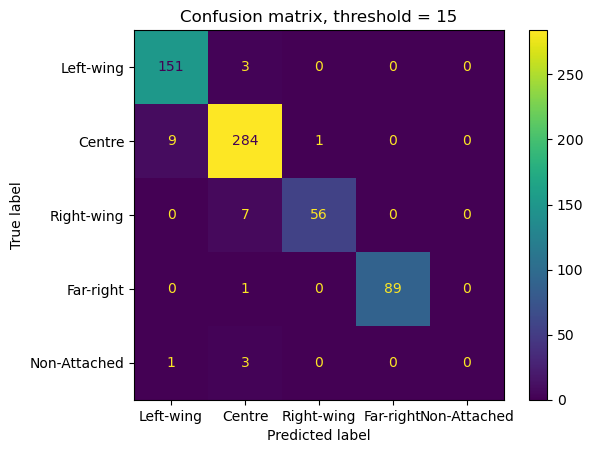

In [39]:
l_pos_na = l_pos+["Non-Attached"]

t = Tree("trees/french_an_maj_+-05.tree",format=1)
memo1 = dict()
th = 15
l_high_lab = l_pos_na
conf_mat = np.zeros((5,5))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo1,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [40]:
th = 15
memo1 = dict()
l_high = l_pos_na
l_col_high = l_col+["#ffffff"]
with open('iTOL/AN/itol_FrenchAN_strip_Bottom-Up_pred.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    f.write("DATA\n")
    

    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,memo1,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")
            

mcc=0.8805949430927732
accuracy: 0.9206611570247933
              precision    recall  f1-score   support

   Left-wing       0.94      1.00      0.97       154
      Centre       0.90      0.95      0.92       294
  Right-wing       0.95      0.57      0.71        63
   Far-right       0.94      0.99      0.96        90
Non-Attached       0.00      0.00      0.00         4

    accuracy                           0.92       605
   macro avg       0.75      0.70      0.71       605
weighted avg       0.92      0.92      0.91       605



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


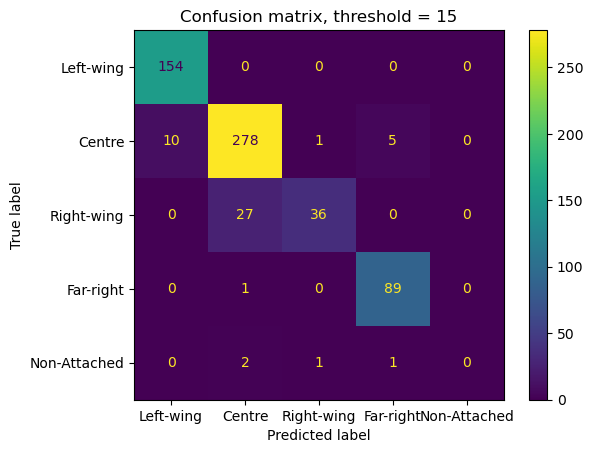

In [41]:
t = Tree("trees/french_an_maj_+-05_Zha.tree",format=1)
memo3 = dict()
th = 15
l_high_lab = l_pos_na
conf_mat = np.zeros((5,5))
y_true = []
y_pred = []
for leaf in t:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = get_pred(leaf,true,memo3,th=th)
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    

disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, threshold = "+str(th))
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [42]:
th = 15
memo2 = dict()
l_high = l_pos_na
l_col_high = l_col+["#ffffff"]
with open('iTOL/AN/itol_FrenchAN_strip_Bottom-Up_Zha_pred.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for leaf in t:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        pred = get_pred(leaf,true,memo2,th=th)
        seq_id = leaf.name
        col = l_col_high[pred]
        label = l_high[pred]
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [43]:
def get_dist_memo(memo,tree):
    if tree.name not in memo:
        lab_count = np.zeros(7)
        for i in tree.get_leaf_names():
            _, idx = leaf_name_to_high_lab(i)
            lab_count[idx] += 1
        memo[tree.name] = lab_count/lab_count.sum()
    return memo[tree.name]

def split(tree,th,memo):
    res = []
    unc = []
    todo = [tree]
    
    while todo:
        curr = todo.pop()
        dist_parent = get_dist_memo(memo,curr)
        if len(curr.children) == 2:
            left,right = curr.children
            dist_left, dist_right = get_dist_memo(memo,left),get_dist_memo(memo,right)
            with warnings.catch_warnings(action="ignore"):
                if (KL(dist_left,dist_parent) > th) or (KL(dist_right,dist_parent) > th):
                    todo.append(left)
                    todo.append(right)
                else:
                    res.append(curr)
        else:
            unc.append(curr)
    return res,unc

In [47]:
t = Tree("trees/french_an_maj_+-05.tree",format=1)
memo1 = dict()

res, unc = split(t,0.4,memo1)
print(len([(i.name,len(i)) for i in res if len(i)>=15]))
print([(i.name,len(i)) for i in res if len(i)>15])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<15]))

5
[('I515', 89), ('I355', 161), ('I107', 248), ('I51', 57), ('I3', 49)]
1


In [48]:
seen = set()
for i in [i for i in res if len(i)>=15]:
    seen.add(l_high_lab[get_dist_memo(memo,i).argmax()])
    print(i.name, l_high_lab[get_dist_memo(memo,i).argmax()],len(i), get_dist_memo(memo,i).max())
set(l_high_lab) - seen

I515 Far-right 89 1.0
I355 Left-wing 161 0.937888198757764
I107 Centre 248 1.0
I51 Right-wing 57 0.9824561403508771
I3 Centre 49 0.7346938775510204


{'Non-Attached'}

In [49]:
unc

[Tree node 'PA719608' (0x7f5dd15fd99)]

mcc=0.9402968551301603
acc_w_na=0.9603305785123967
accuracy: 0.9603305785123967
              precision    recall  f1-score   support

   Left-wing       0.94      0.98      0.96       154
      Centre       0.96      0.97      0.96       294
  Right-wing       0.98      0.89      0.93        63
   Far-right       1.00      0.99      0.99        90
Non-Attached       1.00      0.25      0.40         4

    accuracy                           0.96       605
   macro avg       0.98      0.81      0.85       605
weighted avg       0.96      0.96      0.96       605



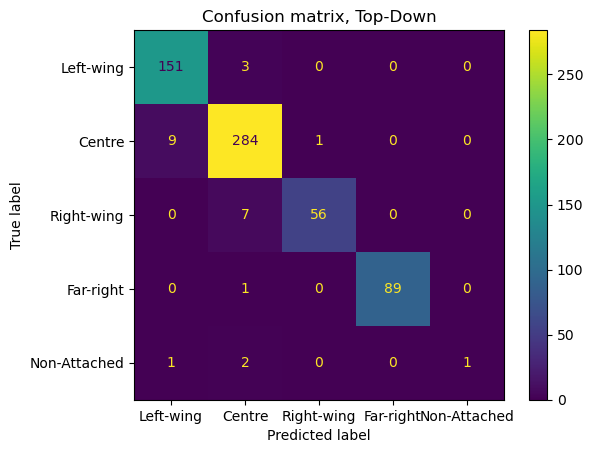

In [50]:
conf_mat = np.zeros((5,5))
y_true = []
y_pred = []
l_pos_na = l_pos+["Non-Attached"]

for st in [i for i in res if len(i)>=15]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
for leaf in unc:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = 4
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [51]:
with open('iTOL/AN/itol_FrenchNA_strip_HBGSP_Top-Down_pred.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for st in [i for i in res if len(i)>=15]: #set of selected subtrees with more than 15 leaves
        pred = get_dist_memo(memo2,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")
    for i in unc:
        pred = 4
        label = l_high[pred]
        col = l_col_high[pred]
        seq_id = i.name
        f.write(seq_id+"\t"+col+"\t"+label+"\n")

In [53]:
t = Tree("trees/french_an_maj_+-05_Zha.tree",format=1)
memo1 = dict()

res, unc = split(t,0.15,memo1)
print(len([(i.name,len(i)) for i in res if len(i)>=15]))
print([(i.name,len(i)) for i in res if len(i)>15])
print(len([i.name for i in unc])+sum([len(i) for i in res if len(i)<15]))

5
[('I497', 95), ('I334', 164), ('I296', 38), ('I198', 104), ('I1', 204)]
0


In [54]:
seen = set()
for i in [i for i in res if len(i)>=15]:
    seen.add(l_high_lab[get_dist_memo(memo,i).argmax()])
    print(i.name, l_high_lab[get_dist_memo(memo,i).argmax()],len(i), get_dist_memo(memo,i).max())
set(l_high_lab) - seen

I497 Far-right 95 0.9368421052631579
I334 Left-wing 164 0.9390243902439024
I296 Right-wing 38 0.9473684210526315
I198 Centre 104 0.7115384615384616
I1 Centre 204 1.0


{'Non-Attached'}

mcc=0.8805949430927732
acc_w_na=0.9206611570247933
accuracy: 0.9206611570247933
              precision    recall  f1-score   support

   Left-wing       0.94      1.00      0.97       154
      Centre       0.90      0.95      0.92       294
  Right-wing       0.95      0.57      0.71        63
   Far-right       0.94      0.99      0.96        90
Non-Attached       0.00      0.00      0.00         4

    accuracy                           0.92       605
   macro avg       0.75      0.70      0.71       605
weighted avg       0.92      0.92      0.91       605



/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/pho/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


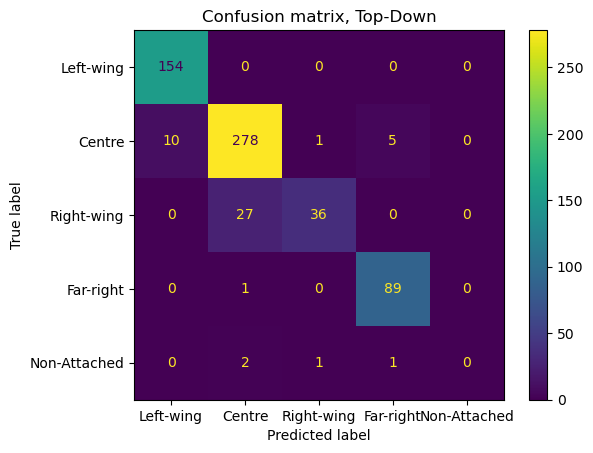

In [55]:
conf_mat = np.zeros((5,5))
y_true = []
y_pred = []
l_pos_na = l_pos+["Non-Attached"]

for st in [i for i in res if len(i)>=15]:
    pred = get_dist_memo(memo,st).argmax()
    for leaf in st:
        high_lab, true = leaf_name_to_high_lab(leaf.name)
        conf_mat[true,pred] += 1
        y_true.append(true)
        y_pred.append(pred)
    
for leaf in unc:
    high_lab, true = leaf_name_to_high_lab(leaf.name)
    pred = 4
    conf_mat[true,pred] += 1
    y_true.append(true)
    y_pred.append(pred)
    
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=l_high_lab)
disp.plot(values_format = '.0f')
plt.title("Confusion matrix, Top-Down")
acc = conf_mat.diagonal().sum()/conf_mat.sum()
acc_w_na = conf_mat.diagonal().sum()/len(t)
mcc = matthews_corrcoef(y_true,y_pred)
print(f"{mcc=}")
print(f"{acc_w_na=}")
print(f'accuracy: {accuracy_score(y_true, y_pred)}')
print(classification_report(y_true, y_pred, target_names=l_high_lab))

In [56]:
with open('iTOL/AN/itol_FrenchNA_strip_Zha_Top-Down_pred.txt','w') as f:
    f.write("DATASET_COLORSTRIP\n")
    f.write("SEPARATOR TAB\n")
    f.write("DATASET_LABEL\tnewsgroup_pred_bottom-up\n")
    f.write("COLOR\t#ff0000\n")
    f.write("LEGEND_TITLE\tNewsgroups_pred_bottom-up\n")
    f.write("LEGEND_SCALE\t1\n")
    f.write("LEGEND_SHAPES"+"\t1"*len(l_high)+"\n")
    f.write("LEGEND_COLORS\t"+"\t".join(l_col_high)+"\n")
    f.write("LEGEND_LABELS\t"+"\t".join(l_high)+"\n")
    
    f.write("DATA\n")
    

    for st in [i for i in res if len(i)>=15]: #set of selected subtrees with more than 15 leaves
        pred = get_dist_memo(memo2,st).argmax()
        label = l_high[pred]
        col = l_col_high[pred]
        for i in st:
            seq_id = i.name
            f.write(seq_id+"\t"+col+"\t"+label+"\n")
            